In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from collections import Counter
import re

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

Using device: cpu


In [3]:
# --- Q1 CONFIG ---
CLOTHES_DIR = './clothes_dataset'  # Ensure this matches your folder name
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

def load_image_data(data_dir):
    images = []
    labels = []
    
    if not os.path.exists(data_dir):
        print("Error: Dataset path not found.")
        return None, None, None

    classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    class_map = {cls: i for i, cls in enumerate(classes)}
    
    print(f"Found {len(classes)} classes: {classes}")
    
    for cls, idx in class_map.items():
        cls_path = os.path.join(data_dir, cls)
        # Limiting to 500 per class to keep training fast for lab
        for i, img_name in enumerate(os.listdir(cls_path)):
            if i >= 500: break 
            try:
                img_path = os.path.join(cls_path, img_name)
                with Image.open(img_path) as img:
                    img = img.resize(IMG_SIZE).convert('RGB')
                    # Transpose for PyTorch: (H, W, C) -> (C, H, W)
                    img_np = np.array(img).transpose((2, 0, 1))
                    images.append(img_np)
                    labels.append(idx)
            except: pass
            
    return np.array(images), np.array(labels), class_map

print("Loading Clothing Data...")
X_img, y_img, class_map_img = load_image_data(CLOTHES_DIR)

# Normalize to [0, 1]
X_img = X_img / 255.0

# Split 80:20
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
    X_img, y_img, test_size=0.2, stratify=y_img, random_state=42
)

# Convert to Tensors
train_dataset_img = TensorDataset(torch.FloatTensor(X_train_img), torch.LongTensor(y_train_img))
test_dataset_img = TensorDataset(torch.FloatTensor(X_test_img), torch.LongTensor(y_test_img))
train_loader_img = DataLoader(train_dataset_img, batch_size=BATCH_SIZE, shuffle=True)
test_loader_img = DataLoader(test_dataset_img, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data loaded. Training shape: {X_train_img.shape}")

Loading Clothing Data...
Found 15 classes: ['Blazer', 'Celana_Panjang', 'Celana_Pendek', 'Gaun', 'Hoodie', 'Jaket', 'Jaket_Denim', 'Jaket_Olahraga', 'Jeans', 'Kaos', 'Kemeja', 'Mantel', 'Polo', 'Rok', 'Sweter']
Data loaded. Training shape: (6000, 3, 64, 64)


In [8]:
# --- REVISED Q1: CNN Model & Training ---
class BetterCNN(nn.Module):
    def __init__(self, num_classes, num_conv_layers=2):
        super(BetterCNN, self).__init__()
        self.num_conv_layers = num_conv_layers
        
        # Layer 1: 64x64 -> 32x32
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        # Layer 2: 32x32 -> 16x16
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        # Layer 3: 16x16 -> 8x8 (Added to reduce parameter count)
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Calculate Flatten Size
        # If 2 layers: 64 channels * 16 * 16 = 16,384
        # If 1 layer: 32 channels * 32 * 32 = 32,768 (Too big! We use AdaptiveAvgPool instead)
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4)) # Forces output to 4x4 spatial size
        self.fc_input_dim = 64 * 4 * 4 if num_conv_layers >= 2 else 32 * 4 * 4
        
        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        if self.num_conv_layers >= 2:
            out = self.layer2(out)
        
        # Apply adaptive pool to force small size regardless of layers
        out = self.adaptive_pool(out) 
        out = out.reshape(out.size(0), -1) 
        out = self.fc(out)
        return out

def train_cnn(model, epochs=10):
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print(f"Training Model with {model.num_conv_layers} Layers...")
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader_img:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # Print loss every epoch to ensure it's dropping
        print(f"  Epoch {epoch+1}: Loss = {running_loss/len(train_loader_img):.4f}")
            
    # Evaluate
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader_img:
            images = images.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return f1_score(all_labels, all_preds, average='macro')

# Run with new model
print("--- Training Standard CNN (2 Layers) ---")
cnn_standard = BetterCNN(num_classes=len(class_map_img), num_conv_layers=2)
f1_standard = train_cnn(cnn_standard, epochs=10) # 10 epochs is enough if it learns
print(f"Standard CNN Macro F1: {f1_standard:.4f}")

print("\n--- Training Shallow CNN (1 Layer) ---")
cnn_shallow = BetterCNN(num_classes=len(class_map_img), num_conv_layers=1)
f1_shallow = train_cnn(cnn_shallow, epochs=10)
print(f"Shallow CNN Macro F1: {f1_shallow:.4f}")

--- Training Standard CNN (2 Layers) ---
Training Model with 2 Layers...
  Epoch 1: Loss = 2.6065
  Epoch 2: Loss = 2.3565
  Epoch 3: Loss = 2.2134
  Epoch 4: Loss = 2.1348
  Epoch 5: Loss = 2.0549
  Epoch 6: Loss = 1.9960
  Epoch 7: Loss = 1.9534
  Epoch 8: Loss = 1.9300
  Epoch 9: Loss = 1.8807
  Epoch 10: Loss = 1.8368
Standard CNN Macro F1: 0.4292

--- Training Shallow CNN (1 Layer) ---
Training Model with 1 Layers...
  Epoch 1: Loss = 2.6235
  Epoch 2: Loss = 2.4762
  Epoch 3: Loss = 2.3822
  Epoch 4: Loss = 2.3005
  Epoch 5: Loss = 2.2515
  Epoch 6: Loss = 2.2044
  Epoch 7: Loss = 2.1587
  Epoch 8: Loss = 2.1193
  Epoch 9: Loss = 2.1025
  Epoch 10: Loss = 2.0564
Shallow CNN Macro F1: 0.3341


In [11]:
import pandas as pd
import numpy as np
import re
import torch
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# --- Q2 CONFIG ---
MAX_VOCAB_SIZE = 5000
MAX_SEQ_LEN = 100
BATCH_SIZE = 32

# 1. Load Data (Robust Method for No-Header CSV)
try:
    # header=None tells pandas there are no column names
    # We load only the first 15,000 rows to keep it fast
    df = pd.read_csv('amazon_reviews.csv', header=None, nrows=15000)
    
    # Based on your error log, the columns are: 0=Label, 1=Title, 2=Text
    df.columns = ['label', 'title', 'text']
    
    print(f"Data Loaded: {len(df)} rows.")
    print(f"Sample Text: {df['text'].iloc[0][:50]}...")
    
    # 2. Fix Labels
    # Amazon datasets usually have 1 = Negative, 2 = Positive
    # We map: 2 -> 1 (Positive), 1 -> 0 (Negative)
    df['target'] = df['label'].apply(lambda x: 1 if x == 2 else 0)
    
    print(f"Label Distribution: {df['target'].value_counts().to_dict()}")

    # 3. Clean and Tokenize
    def clean_text(text):
        text = str(text).lower()
        # Remove special chars
        text = re.sub(r'[^a-z0-9\s]', '', text)
        return text.split()

    all_words = []
    df['tokens'] = df['text'].apply(clean_text)
    
    for tokens in df['tokens']:
        all_words.extend(tokens)

    # Build Vocabulary
    vocab_count = Counter(all_words)
    vocab = {word: i+1 for i, (word, _) in enumerate(vocab_count.most_common(MAX_VOCAB_SIZE))}
    # 0 is reserved for padding

    # 4. Text to Sequence (Padding/Truncating)
    def text_to_seq(tokens):
        seq = [vocab.get(t, 0) for t in tokens][:MAX_SEQ_LEN]
        seq += [0] * (MAX_SEQ_LEN - len(seq)) # Pad with zeros
        return seq

    X_seq = np.array([text_to_seq(t) for t in df['tokens']])
    y_seq = df['target'].values

    # 5. Split Data (80% Train, 10% Val, 10% Test)
    X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # 6. Loaders
    train_loader_nlp = DataLoader(TensorDataset(torch.LongTensor(X_train), torch.FloatTensor(y_train)), batch_size=BATCH_SIZE, shuffle=True)
    val_loader_nlp = DataLoader(TensorDataset(torch.LongTensor(X_val), torch.FloatTensor(y_val)), batch_size=BATCH_SIZE)
    test_loader_nlp = DataLoader(TensorDataset(torch.LongTensor(X_test), torch.FloatTensor(y_test)), batch_size=BATCH_SIZE)

    print("✅ NLP Data Preparation Complete.")

except Exception as e:
    print(f"❌ Error: {e}")

Data Loaded: 15000 rows.
Sample Text: This sound track was beautiful! It paints the sene...
Label Distribution: {1: 7517, 0: 7483}
✅ NLP Data Preparation Complete.


In [14]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score



class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=64, dropout=0.2):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=dropout if dropout > 0 else 0)
        self.fc = nn.Linear(hidden_dim * 2, 1) # *2 because it's bidirectional
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        emb = self.dropout(self.embedding(x))
        
        # lstm_out shape: (batch, seq_len, hidden*2)
        lstm_out, _ = self.lstm(emb)
        
        # Global Average Pooling (Average of all time steps)
        # This is more robust than just taking the last step
        avg_pool = torch.mean(lstm_out, dim=1)
        
        out = self.fc(avg_pool)
        return self.sigmoid(out).squeeze()

def train_bilstm(dropout_val):
    model = BiLSTM(len(vocab), dropout=dropout_val).to(DEVICE)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    
    # Train for 5 epochs
    for epoch in range(5):
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader_nlp:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader_nlp))
        
    # Validation F1
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for inputs, labels in val_loader_nlp:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.numpy())
            
    val_f1 = f1_score(val_targets, val_preds, average='macro')
    return model, train_losses[-1], val_f1

# --- RUN EXPERIMENTS ---
dropout_values = [0.2, 0.4, 0.6]
results = {}

print("--- Running BiLSTM Experiments ---")
for d in dropout_values:
    print(f"Training with Dropout = {d}...")
    model, loss, val_f1 = train_bilstm(d)
    results[d] = {'model': model, 'loss': loss, 'val_f1': val_f1}
    print(f"  -> Train Loss: {loss:.4f} | Val F1: {val_f1:.4f}")

--- Running BiLSTM Experiments ---
Training with Dropout = 0.2...


D:\jupyter_ntb\jupyter_env\Lib\site-packages\torch\nn\modules\rnn.py:990: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  super().__init__("LSTM", *args, **kwargs)


  -> Train Loss: 0.3144 | Val F1: 0.8464
Training with Dropout = 0.4...


D:\jupyter_ntb\jupyter_env\Lib\site-packages\torch\nn\modules\rnn.py:990: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  super().__init__("LSTM", *args, **kwargs)


  -> Train Loss: 0.3344 | Val F1: 0.8239
Training with Dropout = 0.6...


D:\jupyter_ntb\jupyter_env\Lib\site-packages\torch\nn\modules\rnn.py:990: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  super().__init__("LSTM", *args, **kwargs)


  -> Train Loss: 0.4171 | Val F1: 0.7950


In [16]:
import random

def get_noisy_batch(inputs, vocab_size, noise_level=0.1):
    """
    Randomly replaces words with random integers to simulate 
    spelling mistakes or unknown words.
    """
    noisy_inputs = inputs.clone()
    mask = torch.rand(inputs.shape) < noise_level
    # Replace masked items with random word ID (1 to vocab_size)
    random_words = torch.randint(1, vocab_size, inputs.shape).to(DEVICE)
    
    # Apply noise only where mask is True and input is not padding (0)
    noisy_inputs[mask & (inputs != 0)] = random_words[mask & (inputs != 0)]
    return noisy_inputs

def evaluate_model(model, loader, noise=False):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            
            # Apply Noise if requested
            if noise:
                inputs = get_noisy_batch(inputs, len(vocab), noise_level=0.15)
                
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.numpy())
            
    return f1_score(all_targets, all_preds, average='macro')

# 1. Select Best Model
best_dropout = max(results, key=lambda x: results[x]['val_f1'])
best_model = results[best_dropout]['model']
print(f"\nBest Model found with Dropout: {best_dropout}")

# 2. Evaluate on CLEAN Test Data
test_f1_clean = evaluate_model(best_model, test_loader_nlp, noise=False)
print(f"Test F1 (Clean Data): {test_f1_clean:.4f}")

# 3. Evaluate on NOISY Test Data (Spelling mistakes simulation)
test_f1_noisy = evaluate_model(best_model, test_loader_nlp, noise=True)
print(f"Test F1 (Noisy Data): {test_f1_noisy:.4f}")

# 4. Summary Table
print("\n--- Summary of Results ---")
print(f"{'Dropout':<10} | {'Train Loss':<12} | {'Val F1':<10}")
print("-" * 40)
for d, res in results.items():
    print(f"{d:<10} | {res['loss']:.4f}       | {res['val_f1']:.4f}")


Best Model found with Dropout: 0.2
Test F1 (Clean Data): 0.8412
Test F1 (Noisy Data): 0.8080

--- Summary of Results ---
Dropout    | Train Loss   | Val F1    
----------------------------------------
0.2        | 0.3144       | 0.8464
0.4        | 0.3344       | 0.8239
0.6        | 0.4171       | 0.7950


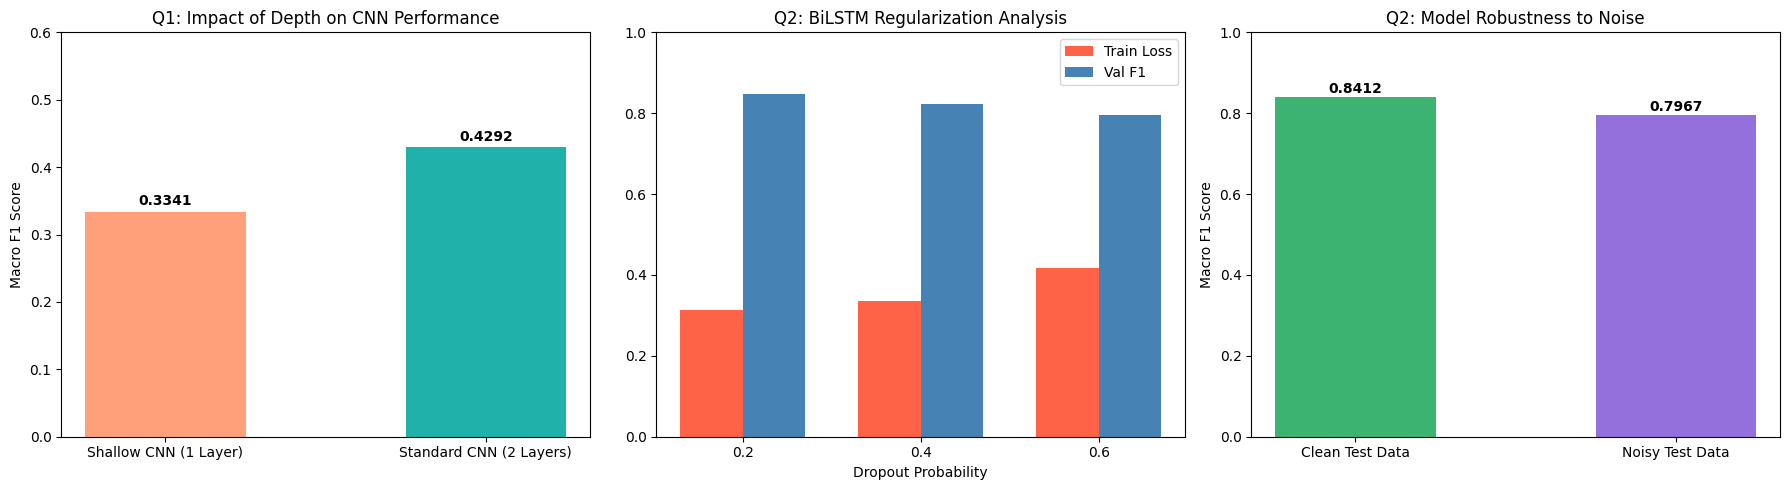

Plot saved as 'lab4_plots.png'


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# --- DATA ---
# Q1: CNN Results
cnn_models = ['Shallow CNN (1 Layer)', 'Standard CNN (2 Layers)']
cnn_f1 = [0.3341, 0.4292]

# Q2: BiLSTM Results
dropout_vals = ['0.2', '0.4', '0.6']
train_loss = [0.3144, 0.3344, 0.4171]
val_f1 = [0.8464, 0.8239, 0.7950]

# Q2: Noise Robustness (Best Model)
robustness_labels = ['Clean Test Data', 'Noisy Test Data']
robustness_scores = [0.8412, 0.7967]

# --- PLOTTING ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: CNN Comparison
axes[0].bar(cnn_models, cnn_f1, color=['#FFA07A', '#20B2AA'], width=0.5)
axes[0].set_title('Q1: Impact of Depth on CNN Performance', fontsize=12)
axes[0].set_ylabel('Macro F1 Score')
axes[0].set_ylim(0, 0.6)
for i, v in enumerate(cnn_f1):
    axes[0].text(i, v + 0.01, str(v), ha='center', fontweight='bold')

# Plot 2: BiLSTM Dropout Analysis
x = np.arange(len(dropout_vals))
width = 0.35
axes[1].bar(x - width/2, train_loss, width, label='Train Loss', color='#FF6347')
axes[1].bar(x + width/2, val_f1, width, label='Val F1', color='#4682B4')
axes[1].set_xticks(x)
axes[1].set_xticklabels(dropout_vals)
axes[1].set_xlabel('Dropout Probability')
axes[1].set_title('Q2: BiLSTM Regularization Analysis', fontsize=12)
axes[1].legend()
axes[1].set_ylim(0, 1.0)

# Plot 3: Noise Robustness
axes[2].bar(robustness_labels, robustness_scores, color=['#3CB371', '#9370DB'], width=0.5)
axes[2].set_title('Q2: Model Robustness to Noise', fontsize=12)
axes[2].set_ylabel('Macro F1 Score')
axes[2].set_ylim(0, 1.0)
for i, v in enumerate(robustness_scores):
    axes[2].text(i, v + 0.01, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('lab4_plots.png', dpi=300)
plt.show()
print("Plot saved as 'lab4_plots.png'")